# Imports

In [1]:
import h5py
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from dataloader import SimpleGraphDataLoader

/home/thomas/.conda/envs/pytorch-cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
mol_paths = glob.glob("graphs_h5/*")
print(len(mol_paths))

1728


In [3]:
def load_structure(path):

    with h5py.File(path, 'r') as file:
        edge_features = torch.tensor(file['edge_attributes'][:], dtype=torch.float32) # Edge attributes
        edge_indices = torch.tensor(file['edge_indices'][:], dtype=torch.long) # Edge (sparse) adjecency matrix
        node_features = torch.tensor(file['node_attributes'][:], dtype=torch.float32) # Node attributes

        r = file['r'][...] # Real space (x-axis)
        pdf = file['pdf'][...] # G(r) (y-axis)

        # Here you can do some normalisation of the node features and perhaps pick out which you want to include.

        graph = Data(x = node_features, y = pdf, edge_attr = edge_features, edge_index = edge_indices)
    return graph

In [4]:
loader = DataLoader([load_structure(path) for path in mol_paths], batch_size=1, shuffle=True)

# Data analytics

In [5]:
num_node_features = set()
num_edge_features = set()
num_node_types = set()
num_edge_types = set()

for data in loader:
    num_node_features.add(data.num_node_features)
    num_edge_features.add(data.num_edge_features)
    num_node_types.add(data['x'][:,0].unique().shape[0])
    num_edge_types.add(data['edge_attr'].unique().shape[0])

In [6]:
print(num_node_features, num_edge_features, num_node_types, num_edge_types)

{7} {1} {2} {1, 2, 3, 4, 5, 6, 7}


Up to 7 different types of bonds?

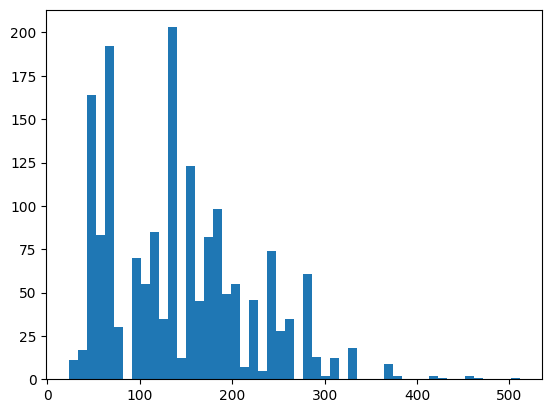

In [7]:
sizes = []

for data in loader:
    sizes.append(data['x'].shape[0])

plt.hist(sizes, bins=50)
plt.show()

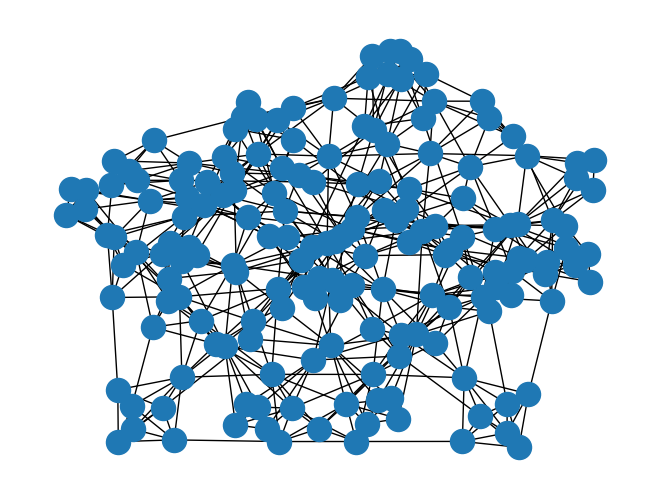

In [8]:
for data in loader:
    g = torch_geometric.utils.to_networkx(data, to_undirected=True)
    nx.draw(g)
    break

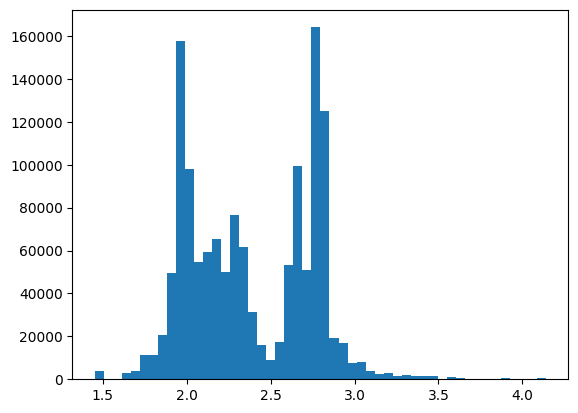

In [9]:
edge_vals = []
for data in loader:
    edge_vals.extend(data['edge_attr'].numpy())
plt.hist(edge_vals, bins=50)
plt.show()

In [10]:
for data in loader:
    edge = data['edge_index'][:,0]
    edge_feature = data['edge_attr'][0]
    edge_nodes = data['x'][edge][:,[-3,-2,-1]]
    node_distance = torch.norm(edge_nodes[0] - edge_nodes[1])
    if node_distance != edge_feature:
        break

In [11]:
num_node_types = []

for data in loader:
    num_node_types.append(data['x'][:,0].unique())
    
print(torch.concat(num_node_types).unique())

tensor([ 3.,  4.,  5.,  8., 11., 12., 13., 14., 19., 20., 21., 22., 23., 24.,
        25., 26., 27., 28., 29., 30., 31., 32., 33., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 55., 56., 72.,
        73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 88.])


In [13]:
size = []
max_nodes = 0
r_r = None

for path in mol_paths[27:]:
    with h5py.File(path, 'r') as file:
        edge_features = torch.tensor(file['edge_attributes'][:], dtype=torch.float32) # Edge attributes
        edge_indices = torch.tensor(file['edge_indices'][:], dtype=torch.long) # Edge (sparse) adjecency matrix
        node_features = torch.tensor(file['node_attributes'][:], dtype=torch.float32) # Node attributes

        r = file['r'][...] # Real space (x-axis)
        pdf = file['pdf'][...] # G(r) (y-axis)
        
        if r_r is None:
            r_r = r
        else:
            assert (r_r == r).all()
    

In [21]:
np.linspace(0,30,3000)[-1]

30.0

In [18]:
r_r[-1]

29.990000000000002

In [ ]:
loader2 = SimpleGraphDataLoader('graphs_h5', batch_size=1, shuffle=True, metals=["Ag", "Au"])

64 1728 ['ag', 'au']
